In [148]:
#INTERSECTION SEGMENTS

# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [ ]:
# Python Standard Library
# -----------------------
pass

In [90]:
# Third-Party Libraries
# ---------------------
%matplotlib inline
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
#import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [91]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [92]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [93]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [94]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [95]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [96]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2

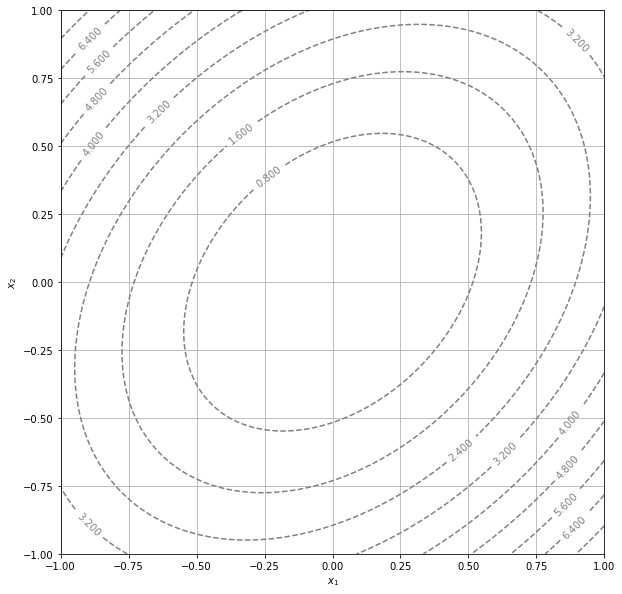

In [97]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [98]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

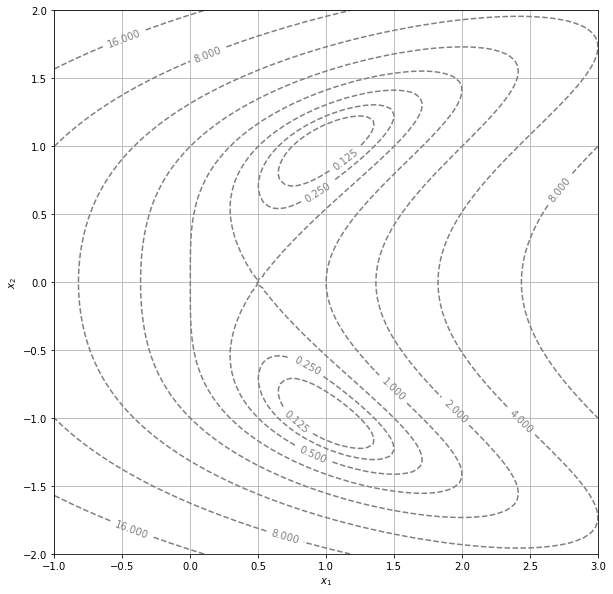

In [99]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [100]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

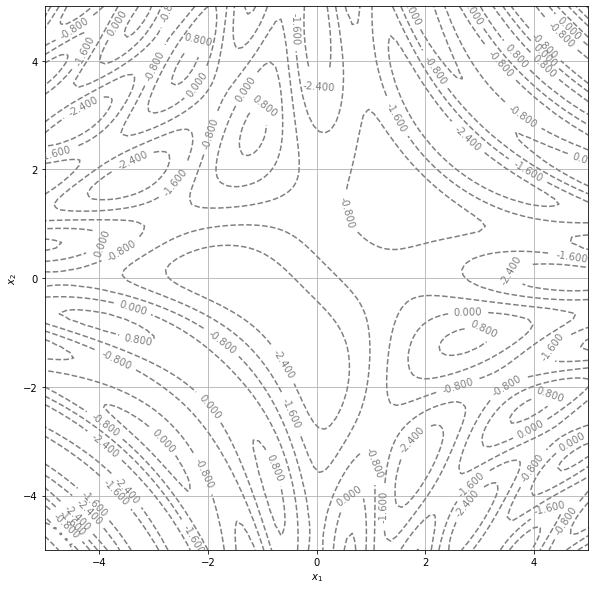

In [101]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$



#### Question 1 :
Soit $c \in \mathbb{R}$
, on note $E  = \{(x,y) \in \mathbb{R^2} \ | \ f(x,y) = c \}$

Comme  {c} est un fermé de $\mathbb{R}$ et par continuité de $f$, $f^{-1}(\{c\})$ est un fermé de $\mathbb{R^2}$.

Montrons maintenant que $E$ est borné : 

Comme, $f(x,y) \underset{||(x,y)|| \to + \infty} \to + \infty$

Ainsi, il existe $b$, $b \in \mathbb{R_+}$, tel que :

$\forall (x,y) \in \mathbb{R^2}, ||(x,y)|| \geqslant b \implies f(x,y) \gt c$.

$\forall (x,y) \in E, ||(x,y)|| \le b$.

Donc $E$ est borné. Ainsi, $E$ est un fermé borné de $\mathbb{R^2}$, donc un compact de $\mathbb{R^2}$.

#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

On remarque que $\forall(x_1, x_2)\in \mathbb{R^{2}} :$
$\newline$
$p(x_1,x_2) = \frac{1}{||\nabla \vec f(x_0)||}\det(\begin{pmatrix}
x_1-x_{10}\\
x_2-x_{20}
\end{pmatrix},\nabla \vec f(x_0))$
$\newline$
Ainsi, $p$ représente l'$aire$ induite par un vecteur déplacement  $\begin{pmatrix}
\Delta x_1\\
\Delta x_2
\end{pmatrix}$ et le gradient de $f$ en $x_0$.
$\newline$
On en déduit que $p$ s'annule lorsque on se déplace collinéairement a $\nabla \vec f(x_0)$.

------------

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Question 3 : 
 
On définit $g : \mathbb{R^3} \to \mathbb{R^2}$ par :

$g :(x_1,x_2,t) \mapsto (f(x_1,x_2)-c, \ p(x_1,x_2)-t)$

On veut appliquer le $Théorème\ des\ fonctions\ implicites$ à la fonction $g$ :

- $g$ est continuement differentiable car $f$ l'est par definition et $p$ est un polynome en les coordonnées.
- le determinant de la jacobienne
  
   $\partial_x g(x_1,x_2,t) = \begin{pmatrix} 
  \partial_1f(x_1,x_2)&\partial_2f(x_1,x_2)\\
  \frac{\partial_1f(\vec x_0)}{||\nabla f(\vec x_0)||}&-\frac{\partial_1f(\vec x_0)}{||\nabla f(\vec x_0)||}\\
  \end{pmatrix}$ 


  vaut -||$\nabla f(\vec x_0)|| \ne 0$ en $x_0$, ainsi par continuité du gradient ( $f$ continuement differentiable), il existe un ouvert $U$ de $\mathbb{R^2}$ tq:
  - $(x_0,y_0) \in U$   


  - $\forall \vec x \in U,  \ ||\nabla f(\vec x)|| \ne 0$, donc  $\partial_x g(\vec x,t)$ inversible dans U
- enfin, on choisit un $\delta > 0,$ et on restreint $g$ à
   $W = U\times ]-\delta,\delta[$, on a donc  $(x_0,y_0,0) \in W$ et qui annule $g$


Ainsi par le $théorème \ des \ fonctions \  implicites$ :
  - il existe des voisinages $U'$ de $\vec x_0$, $V de \ 0$ (du type $]- \epsilon,\epsilon[$], où $0<\epsilon \le \delta$) tel que $U' \times V \subset W$ et une unique fonction implicite $\gamma : V \longrightarrow \mathbb{R^2}$, continuement différentiable, telle que $\forall (t, \vec x)\in V \times U'$ :
  
  $g(\vec x,t)=0  \Leftrightarrow (f( \vec x) = c \ \ et \ t=p(\vec x))  \Leftrightarrow \gamma(t)=\vec x$ d'où le résultat escompté.

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

#### Question 4 : 

- La suite du théoreme des fonctions implicites nous donne l'expression de $\gamma'$ :
$\newline$
$\forall t\in ]-\epsilon,\epsilon[$ :
$d\gamma(t) = \gamma'(t) =-(\partial_xg(\gamma(t), t))^{-1}$ . $\partial_tg(\gamma(t), t)$ 
 = $\frac{||\nabla f(\vec xo)||}{A} \begin{pmatrix}
\partial_2 f(\vec x)\\
-\partial_1 f(\vec x)
\end{pmatrix}$
$\newline$
avec $A =\partial_1f(\vec x_0) \partial_1f(\vec x) + \partial_2f(\vec x_0) \partial_1f(\vec x) \ne 0$ d'apres la question precedente.
$\newline$

- De plus, si $\gamma'(t) = 0$, le gradient de $f$ en $\vec x$ est nul. Donc quitte à réduite l'intervalle de definition de $\gamma$, en utilisant le fait que $||\nabla f(\vec x_0)||$ $\ne 0$, àl'aide de la continuité du gradient, on peut trouver un ouvert $]\epsilon',\epsilon'[$ inclus dans $]\epsilon,\epsilon[$ où $\gamma'$ est non nul.
On aurait pu s'y restreindre dès le debut.
$\newline$

- et directement :
$<\gamma'(t),\nabla f(\gamma(t))> \ =B*(\partial_1f(\vec x)\partial_2f(\vec x)-\partial_1f(\vec x)\partial_2f(\vec x))=0$
Donc  $\gamma'(t) \perp \nabla f(\gamma(t))$

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [102]:
eps = 1e-12
N = 100

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [103]:
def Newton(F, x0, y0, eps = eps, N = N):
    x, y = float(x0), float(y0) #On convertit en float car les algorithmes de autograd ne semblent pas fonctionnent pas avec des entiers
    Jacob_f  = J(F)
    for i in range(N):
        invJF_xy = np.linalg.inv(Jacob_f(x,y))
        a = np.array([x, y]) - np.dot(invJF_xy, F(x,y)) #On applique l'algorithme de Newton
        x, y = float(a[0]), float(a[1])
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps: 
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

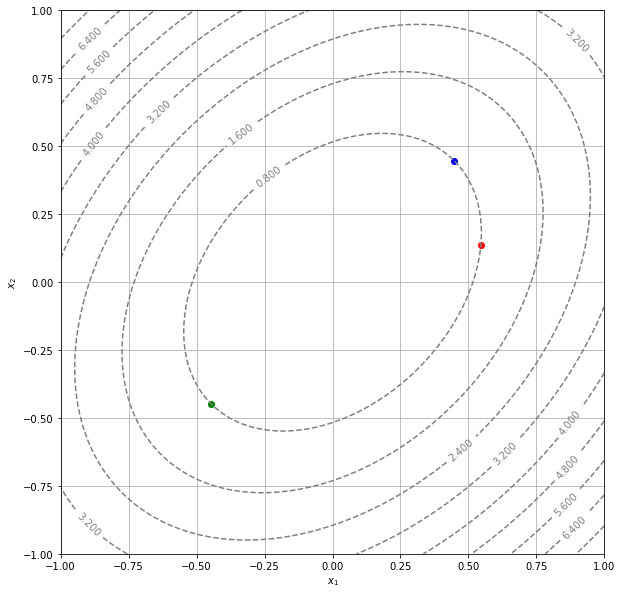

In [104]:
def p(x1, x2) :
    return x1 - x2

c = 0.8

def F1(x, y) :
    return np.array([f1(x, y) - c, x - y])

def F2(x,y) :
    return np.array([f1(x, y) - c, x - 4 * y])

#On modfidie la fonction display_contour pour afficher nos points et valider notre programme.
def display_contourv2(f, x, y, levels) :
    #On essaye avec plusieurs points
    x1, y1 = Newton(F1, 0.8, 0.8)
    x2, y2 = Newton(F2, 0.8, 0.8) #on fait varier la contrainte
    x3, y3 = Newton(F1, - 0.1, - 0.1) #Et le point de départ
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
   
    # on affiche le graphique les points trouvés par nos versions de la fonction de Newton
    
    plt.scatter(x1, y1, color = 'b') 
    plt.scatter(x2, y2, color = 'r') 
    plt.scatter(x3, y3, color = 'g') 
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")


display_contourv2(
    f1, 
    x = np.linspace(-1.0, 1.0, 100), 
    y = np.linspace(-1.0, 1.0, 100), 
    levels = 10, 
)

#On constate que le programme semble marcher comme souhaité


#(0.44,0.44) est bien un point de la courbe de niveau 0.8 de f1
     

En vue d'une generalisation, on pourrait choisir comme deuxième coordonnée de la fonction $F$ :
$\newline$
$F :(x,y) \mapsto (f(x, y) - c, p(x,y))$
$\newline$
En effet, quand $p$ s'annule, c'est qu'on se deplace orthogonalement à une courbe de niveau, donc $f(\vec x)$ "augmente ou diminue", ainsi on se rapproche de la courbe de niveau c.

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

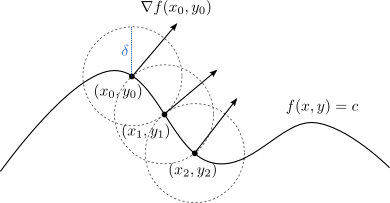

In [105]:
#Implémentation 1
def level_curve1(f, x0, y0, delta = 0.1, N = 200, eps = eps, c = 0.0):
    #on ajoute une constante c pour gérer la courbe de niveau.
    
    def h(x, y) :
        return  ((x - x0)**2 + (y - y0)**2)**(0.5) - delta #on crée une fonction qui permet d'avoir (x,y) à une distance delta de (x0,y0)
    def F(x, y) :
        return np.array([f(x, y) - c, h(x, y)]) #On crée notre fonction de R^2 dans R^2
    
    liste_points = [(x0, y0)]
    gradf = grad(f) 
    
    for i in range(0, N-1) :
        
        grad_x, grad_y = gradf(x0, y0)[0], gradf(x0, y0)[1] #On calcule le gradient
        #On veut partir "vers la droite", pour cela on applique une rotation de -90° au gradient, on normalise ensuite le vecteur obtenu.
        rotation_grad = np.array([grad_y, - grad_x])/np.linalg.norm(np.array([grad_x, grad_y]))
        #On veut maintenant partir "assez loin"
        direction = rotation_grad * delta 
        #le point (x0 + direction[0], y0 + direction[1]) est situé assez loin de (x0,y0) pour qu'il soit intéressant d'appliquer
        #une méthode de Newton en partant de lui.
        x1, y1 = Newton(F, direction[0] + x0, direction[1] + y0)
        #la méthode de Newton nous permet ainsi d'obtenir un point situé sur la courbe de niveau de f, mais également à une distance
        #supérieure à delta grâce à la deuxième composante du vecteur image de F (situé précisément à (3/2)*delta de (x0,y0))
        liste_points.append((x1, y1))
        x0, y0 = x1, y1
    liste_x = []
    liste_y = []
    for e in liste_points :
        liste_x.append(e[0])
        liste_y.append(e[1])
    return [liste_x, liste_y]

#level_curve1(f1, 0.44, 0.44, 0.2, c = 0.8)

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

In [106]:
#Implémentation 2
def level_curve2(f, x0, y0, delta = 0.1, N = 200, eps = eps, c = 0.0):
    #on ajoute une constante c pour gérer la courbe de niveau.
    
    def h(x, y) :
        return  ((x - x0)**2 + (y - y0)**2)**(0.5) - delta #on crée une fonction qui permet d'avoir (x,y) à une distance delta de (x0,y0)
    def F(x, y) :
        return np.array([f(x, y) - c, h(x, y)]) #On crée notre fonction de R^2 dans R^2
    
    liste_points = [(x0, y0)]
    
    for i in range(0, N-1) :
        gradf = grad(f)
        grad_x, grad_y = gradf(x0, y0)[0], gradf(x0, y0)[1]
        
        rotation_grad = np.array([grad_y, - grad_x])/np.linalg.norm(np.array([grad_x, grad_y]))
        direction = rotation_grad * delta 
        
        x1, y1 = Newton(F, direction[0] + x0, direction[1] + y0)
        liste_points.append((x1, y1))
        x0, y0 = x1, y1

        #--------------Ajout level curve 2 ------------------
            #On teste la distance entre le premier et le dernier point. Si cette dernière est inferieure a 0.9 * delta,
            #alors on a fait le tour de la courbe de niveau, a la condition raisonnable près :
            # "la courbe de niveau ne boucl pas sur elle meme"
        if ((liste_points[0][0]-liste_points[-1][0])**2 + (liste_points[0][1] - liste_points[-1][1])**2)**(0.5) < delta : 
            liste_x = []
            liste_y = []
            for e in liste_points :
                liste_x.append(e[0])
                liste_y.append(e[1])
            return [liste_x,liste_y]
        #-----------------------STOP--------------------------
        
    liste_x = []
    liste_y = []
    for e in liste_points :
        liste_x.append(e[0])
        liste_y.append(e[1])
    return [liste_x, liste_y]

#level_curve2(f1, 0.44, 0.44, 0.2, c = 0.8)

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

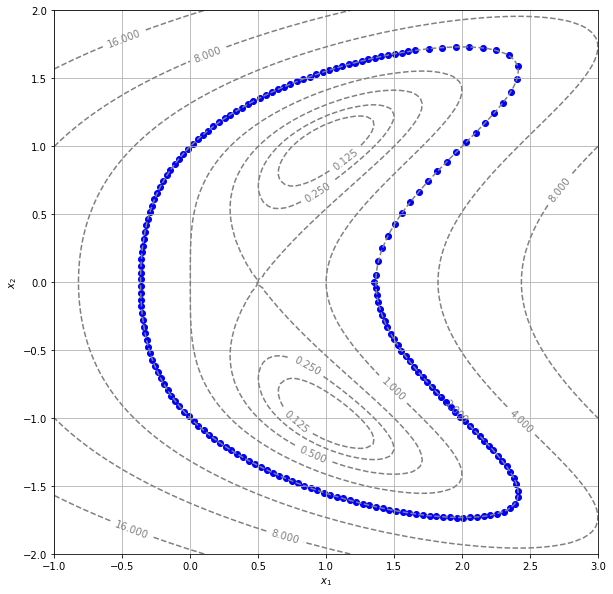

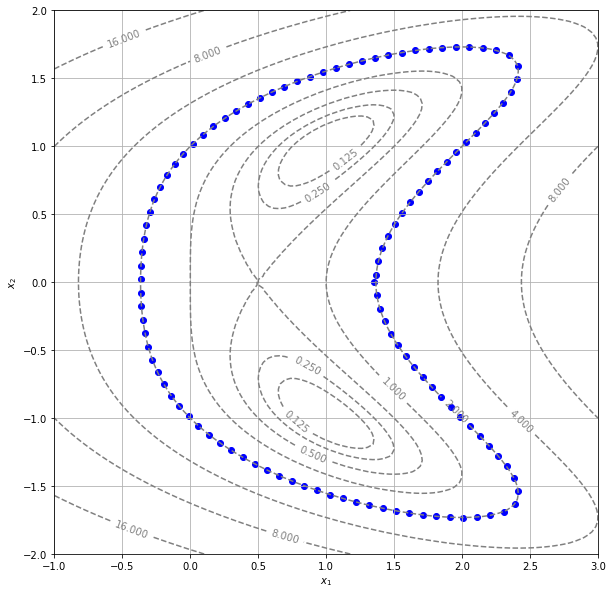

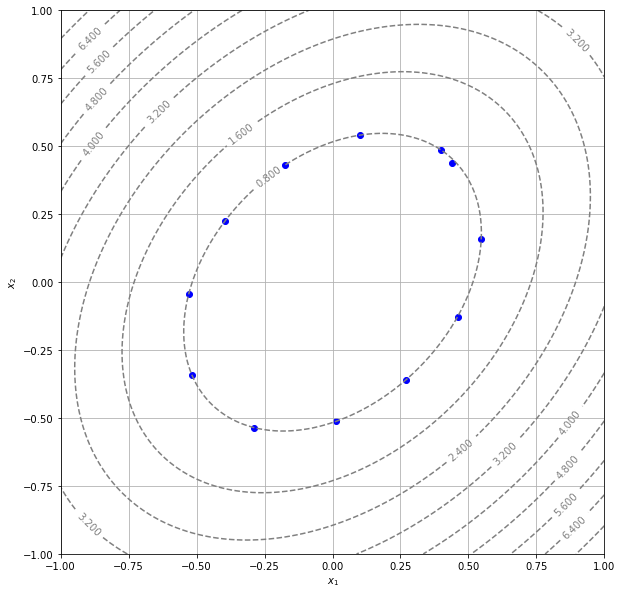

In [107]:
#On modfidie la fonction display_contour pour afficher nos points et valider notre programme.
def display_contourv2(f, x, y, levels, x0, y0, delta, version, c = 0.0) :
    #On génère la liste des points situés sur la courbe de niveau, en fonction de la version du programme demandé.
    if version == 1 :
        liste_points = level_curve1(f, x0, y0, delta, c = c)
    else : 
        liste_points = level_curve2(f, x0, y0, delta, c = c)
    
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors = "grey", linestyles = "dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    
    liste_x = liste_points[0]
    liste_y = liste_points[1]
   
    # on affiche le graphique les points trouvés par notre fonction
    
    plt.scatter(liste_x, liste_y, color = 'b') 
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#On affiche les points rendus par la première version
#On constate un recouvrement

display_contourv2(f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)],
    x0 = 1.35,
    y0 = 0.0,
    delta = 0.1,
    version = 1,
    c = 2.0)

#On affiche les points rendus par la seconde version
#Il n'y a plus de recouvrement
display_contourv2(f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)],
    x0 = 1.35,
    y0 = 0.0,
    delta = 0.1,
    version = 2,
    c = 2.0)

display_contourv2(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10, # 10 levels, automatically selected
    x0 = 0.44,
    y0 = 0.44,
    delta = 0.3,
    version = 2,
    c = 0.8
)

#On constate que le programme semble marcher comme souhaité, dès lors que delta n'est pas trop élevé ( delta doit rester faible,
#sinon on ne peut pas trouver de point si la courbe "tourne beaucoup" )

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Question 8 :

Soit deux points du plan $P_1=(p_{1x},p_{1y})$ et $P_2=(p_{2x},p_{2y})$, et deux vecteurs directeurs $u_1=\begin{pmatrix}
u_{1x}\\
u_{1y}
\end{pmatrix}$
et $u_2=\begin{pmatrix}
u_{2x}\\
u_{2y}
\end{pmatrix}$.

On cherche à lier les points $P_1$ et $P_2$ par un arc parametré $\gamma$ binomial du type : 

pour $t\in \mathbb{R}$,  $\gamma(t)=\begin{pmatrix}
a+bt+ct^{2}\\
d+et+ft^{2}
\end{pmatrix}$ vérifiant :
 - $\gamma(0)=P_1 \Leftrightarrow \begin{pmatrix}
a\\
d
\end{pmatrix}$ = $\begin{pmatrix}
p_{1x}\\
p_{1y}
\end{pmatrix}$ $\newline$
 $\gamma(1)=P_2 \Leftrightarrow \begin{pmatrix}
a+b+c\\
d+e+f
\end{pmatrix}$ = $\begin{pmatrix}
p_{2x}\\
p_{2y}
\end{pmatrix}$
- $\exists (\lambda,\mu) \in (\mathbb{R^{*}_{+}})^{2}$ tel que: $\newline$ 
  - $\gamma'(0)=\lambda u_1 \Leftrightarrow \begin{pmatrix}
b\\
e
\end{pmatrix}$ = $\begin{pmatrix}
\lambda u_{1x}\\
\lambda u_{1y}
\end{pmatrix}$ 
  - $\gamma'(1)=\mu u_2 \Leftrightarrow \begin{pmatrix}
b+2c\\
e+2f
\end{pmatrix}$ = $\begin{pmatrix}
\mu u_{2x}\\
\mu u_{2y}
\end{pmatrix}$ 

On a donc 8 équations pour 8 inconnues (en comptant $\lambda$ et $\mu$ qui ne semblent pas forcement arbitraire)
On resoût le systeme et on obtient les resultats suivant :
$\newline$
$a=p_{1x}$
$\newline$
$d=p_{1y}$
$\newline$
$b=\lambda u_{1x}$
$\newline$
$e=\lambda u_{1y}$
$\newline$
$c=p_{2x}-p_{1x}-\lambda u_{1x}$
$\newline$
$f=p_{2y}-p_{1y}-\lambda u_{1y}$
$\newline$
avec $\lambda = 2\frac{det(\vec {P_1P_2}, \vec u_2)}{det(\vec u_1,\vec u_2)}$

De là on peut en deduire plusieurs contraintes :

Comme $\lambda$ ne peut etre nul si on veut respecter les conditions sur les derivées, on a:
- $P_1$ et $P_2$ ne peuvent être confondus.

Pour que $\lambda$ soit bien défini
- $\vec u_1$ et $\vec u_2$ ne peuvent pas être des vecteurs nuls (mais le sujet les définit comme tels)
- il faut que $\vec u_1$ et $\vec u_2$ ne soient pas parallèles . Cela semble logique ''car on travaille avec une paramétrisation polynomiale''

Enfin, pour respecter $\lambda >0$ : 
 - Ou bien les angles $(\vec P_1P_2,  \vec u_2)$ et $(\vec u_1,  \vec u_2)$ sont tous les deux obtus, ou bien tous les deux sont aigües.

Dans notre cas, $u_1$ et $u_2$ seront des tangentes à la courbe en $P_1$ et $P_2$, ainsi en supposant $\delta$ assez petit et la fonction suffisament regulière, nous pourrons considérer que la deuxieme option sera toujours respectée.


#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [145]:
def gamma(t, P1, P2, u1, u2): 
    #vectorisation des listes
    P12 = np.array((P2[0] - P1[0], P2[1] - P1[1]))
    
    det_u1_u2 =2 * np.linalg.det([u1,u2])
    #tests : 
    if P1 == P2 :
        return 
    if abs(det_u1_u2) <=  0.1 :
         return (P1[0] + (P2[0] - P1[0]) * t, P1[1] + (P2[1] - P1[1]) * t )
    else :
        lbd = 2 * np.linalg.det([P12,u2])/det_u1_u2
        a = P1[0]
        d = P1[1]
        b = lbd * u1[0]
        e = lbd * u1[1]
        c = P2[0] - P1[0] - lbd * u1[0]
        f = P2[1] - P1[1] - lbd * u1[1]          
        return (a + b * t + c * (t**2), d + e*t + f*(t**2))

    
def gamma_vect(T, P1, P2, u1, u2):
    liste_points = [[],[]]
    for e in T :
        liste_points[0].append(gamma(e, P1, P2, u1, u2)[0])
        liste_points[1].append(gamma(e, P1, P2, u1, u2)[1])
        

    return liste_points




### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [146]:
#Implémentation 3
def level_curve3(f, x0, y0, oversampling, delta = 0.1, N = 200, eps = eps, c = 0.0):
    #on ajoute une constante c pour gérer la courbe de niveau.
    if oversampling == 1 :
        return level_curve(f, x0, y0, delta, N, eps, c)
    else :
        
        def h(x, y) :
            return  ((x - x0)**2 + (y - y0)**2)**(0.5) - delta #on crée une fonction qui permet d'avoir (x,y) à une distance delta de (x0,y0)
        def F(x, y) :
            return np.array([f(x, y) - c, h(x, y)]) #On crée notre fonction de R^2 dans R^2

        liste_points = [[x0], [y0]]
        liste_points_interpoles = [[],[]]
        #on crée une listes qui contiendra les points interpolés.

        for i in range(0, N-1) :
            gradf = grad(f)
            grad_x, grad_y = gradf(x0, y0)[0], gradf(x0, y0)[1]

            rotation_grad = np.array([grad_y, - grad_x])/np.linalg.norm(np.array([grad_x, grad_y]))
            direction = rotation_grad * delta 

            x1, y1 = Newton(F, direction[0] + x0, direction[1] + y0)

            #----------Nouveauté de curve 3 :-------------

            grad_x1, grad_y1 = gradf(x1, y1)[0], gradf(x1, y1)[1]
            
            P1 = (x0, y0)
            P2 = (x1, y1)
            u1 = np.array([ grad_y, - grad_x])
            u2 = np.array([ grad_y1, - grad_x1])
            
            points = np.linspace(0,1,oversampling,endpoint=False)[1:]
            
            interpolex, interpoley = gamma_vect(points, P1, P2, u1, u2)
            
            #-----------------STOP--------------------------    
            
            liste_points[0].append(x1)
            liste_points[1].append(y1)
            
            liste_points_interpoles[0] = liste_points_interpoles[0] + interpolex
            liste_points_interpoles[1] = liste_points_interpoles[1] + interpoley
            
            x0, y0 = x1, y1
            if ((liste_points[0][0]-liste_points[0][-1])**2 + (liste_points[1][0] - liste_points[1][-1])**2)**(0.5) < delta  : 

                #---------------suite nouveautés curve 3----------------
                          # on interpole entre le premier et le dernier point : 

                x_init, y_init = liste_points[0][0], liste_points[1][0]
                x_fin, y_fin = liste_points[0][-1], liste_points[1][-1]

                grad_x_init,grad_y_init = gradf(x_init,y_init)[0],gradf(x_init,y_init)[1]
                grad_x_fin,grad_y_fin = gradf(x_fin,y_fin)[0],gradf(x_fin,y_fin)[1]

                u1 = np.array([grad_y_init, grad_x_init])
                u2 = np.array([grad_y_fin, -grad_x_fin])

                points = np.linspace(0,1,oversampling,endpoint=False)[1:]
                interpolex, interpoly = gamma_vect(points,(x_init, y_init),(x_fin, y_fin), u1, u2)

                liste_points_interpoles[0] = liste_points_interpoles[0] + interpolex
                liste_points_interpoles[1] = liste_points_interpoles[1] + interpoley   
                 #---------------------STOP-------------------- 
                return  liste_points, liste_points_interpoles

        return  liste_points, liste_points_interpoles

#level_curve3(f2, 1.35 , 0.0, 3, delta = 0.2, c = 2)

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

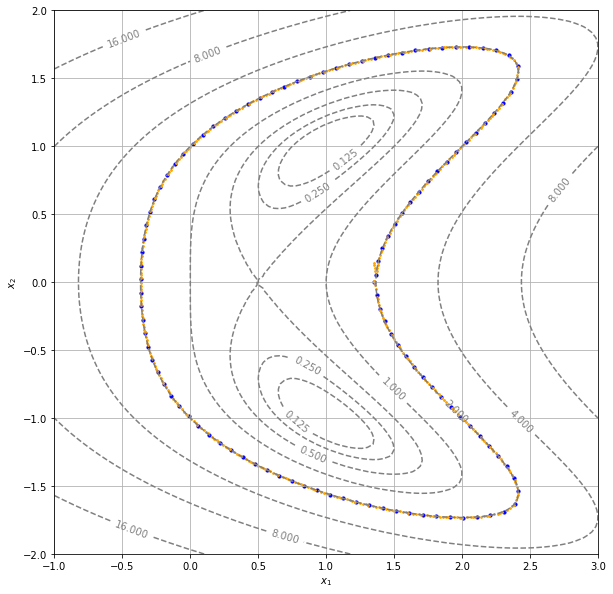

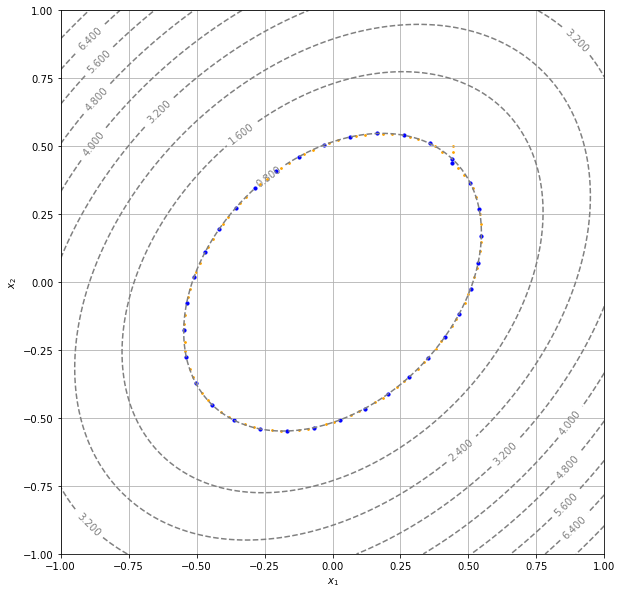

In [147]:
#On modfidie la fonction display_contour pour afficher nos points et valider notre programme.
def display_contourv3(f, x, y, levels, x0, y0, oversampling, delta, version, c = 0.0) :
    #On génère la liste des points situés sur la courbe de niveau, en fonction de la version du programme demandé.
    if version == 1 :
        liste_points = level_curve1(f, x0, y0, delta, c = c)
    elif version == 2 :
        liste_points = level_curve2(f, x0, y0, delta, c = c)
    else :
        liste_points, liste_points_interpoles = level_curve3(f, x0, y0, oversampling, delta, c = c)
    
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors = "grey", linestyles = "dashed", 
        levels = levels 
    )
    ax.clabel(contour_set)
   
    # on affiche sur le graphique les points trouvés par notre fonction
    
    plt.scatter(liste_points[0], liste_points[1], s = 10, color = 'b') 
    if version == 3 :
        plt.scatter(liste_points_interpoles[0], liste_points_interpoles[1], s = 3, color = "orange")
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")


display_contourv3(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)], # levels: [0.125, 0.25, ..., 64, 128]
    x0 = 1.35,
    y0 = 0.0,
    oversampling = 5,
    delta = 0.1,
    version = 3,
    c = 2.0
)


display_contourv3(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10, # 10 levels, automatically selected
    x0 = 0.44,
    y0 = 0.44,
    oversampling = 3,
    delta = 0.1,
    version = 3,
    c = 0.8
)

#On constate que le programme semble marcher comme souhaité